In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 

# Get celebA dataset

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [6]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [9]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

class MinMax(object):
    def __init__(self, mean0=True):
        self.mean0 = mean0
        pass
    def __call__(self, img):
        return torch.Tensor(min_max(cuda2numpy(img), mean0=self.mean0))
    def __repr__(self):
        return self.__class__.__name__

transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

In [10]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


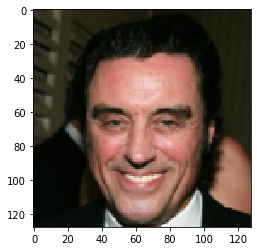

In [11]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

# conditional GAN

In [12]:
torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# ---- adjustable parameters ---- #
ndim = 8 # the dimension of noise vector, indicating the style
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4
###################################

ref_label = np.eye(len(classes))
criterion = nn.MSELoss()
criterion_class = nn.MSELoss()

## Results

In [14]:
import pandas as pd
def get_adjustable_parameters(notebook_no=1):
    if notebook_no == 3: 
        models = [["conventionalKL", False],
                  ["conventionalKL", True],
                  ["proposedKL", False],
                  ["proposedKL", True]]
        columns=["restriction_type", "styleINdataset"]
    return pd.DataFrame(np.array(models), columns=columns)
get_adjustable_parameters(3)

,restriction_type,styleINdataset
0,conventionalKL,False
1,conventionalKL,True
2,proposedKL,False
3,proposedKL,True


In [15]:
###############################################
############ adjustable parameters ############

restriction_type = "conventionalKL" # "conventionalKL", "proposedKL"
styleINdataset = False

###############################################
###############################################

model_type = "nopretraining" # "nopretraining", "gradattention", "pretrained"
attention_mode = "" # this will be available when you set 'model_type' as "gradattention": "relu", "relumodified"

if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"
if styleINdataset:
    styleINdataset_or_not = "styleINdataset_"
else:
    styleINdataset_or_not = ""
    
lbd = {}
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["class"] = 1
lbd["reg"] = 0.5
lbd["idt_reg"] = 0.5
lbd["gp"] = 0
lbd["consis_reg"] = 0

if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100
    
if (model_type=="gradattention") and (attention_mode=="relumodified"):
    lbd["class_enc"] = 10
    lbd["attention"] = 1000
else:
    lbd["class_enc"] = 0
    lbd["attention"] = 0

unrolled_k = 5

In [16]:
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
if model_type in ["nopretraining", "pretrained"]:
    netE = Encoder(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
elif model_type=="gradattention":
    netE = Encoder_gradattention(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], attention_mode).to(device)
sg = SRGAN_training([netG, netD, netE], [None, None, None], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, None, encoded_feature, styleINdataset, ndim)
sg.opt_sche_initialization()

In [17]:
load_epoch = 30
dir = "../data/parameters/03/"
# dir = "./instant_model_parameter/"
if model_type == "nopretraining":
    gen_path = dir + f"gen_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
    enc_path = dir + f"enc_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"

elif model_type == "pretrained":
    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"

elif model_type == "gradattention":
    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"

gen_model = torch.load(gen_path)
enc_model = torch.load(enc_path)

netG.load_state_dict(gen_model)
netE.load_state_dict(enc_model)
gen_path

'../data/parameters/03/gen_modified_SingleGAN_idt5_cycle5_gp0_KL0.1_reg0.5_classenc0_idtreg0.5_attention0_consisreg0_unrolledk5_epoch30.pth'

In [18]:
num = 100
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [19]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    _, mu, _, _, _ = netE(data_image)
    if itr==0:
        samples = cuda2cpu(data_image)
        labels = cuda2cpu(data_label)
        mu_list = cuda2cpu(mu)
    else:
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
if styleINdataset:
    latent = mu_list
else:
    latent = np.random.randn(num, ndim)

In [20]:
index = len(testset) - 11
target_label = 2
data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=False)

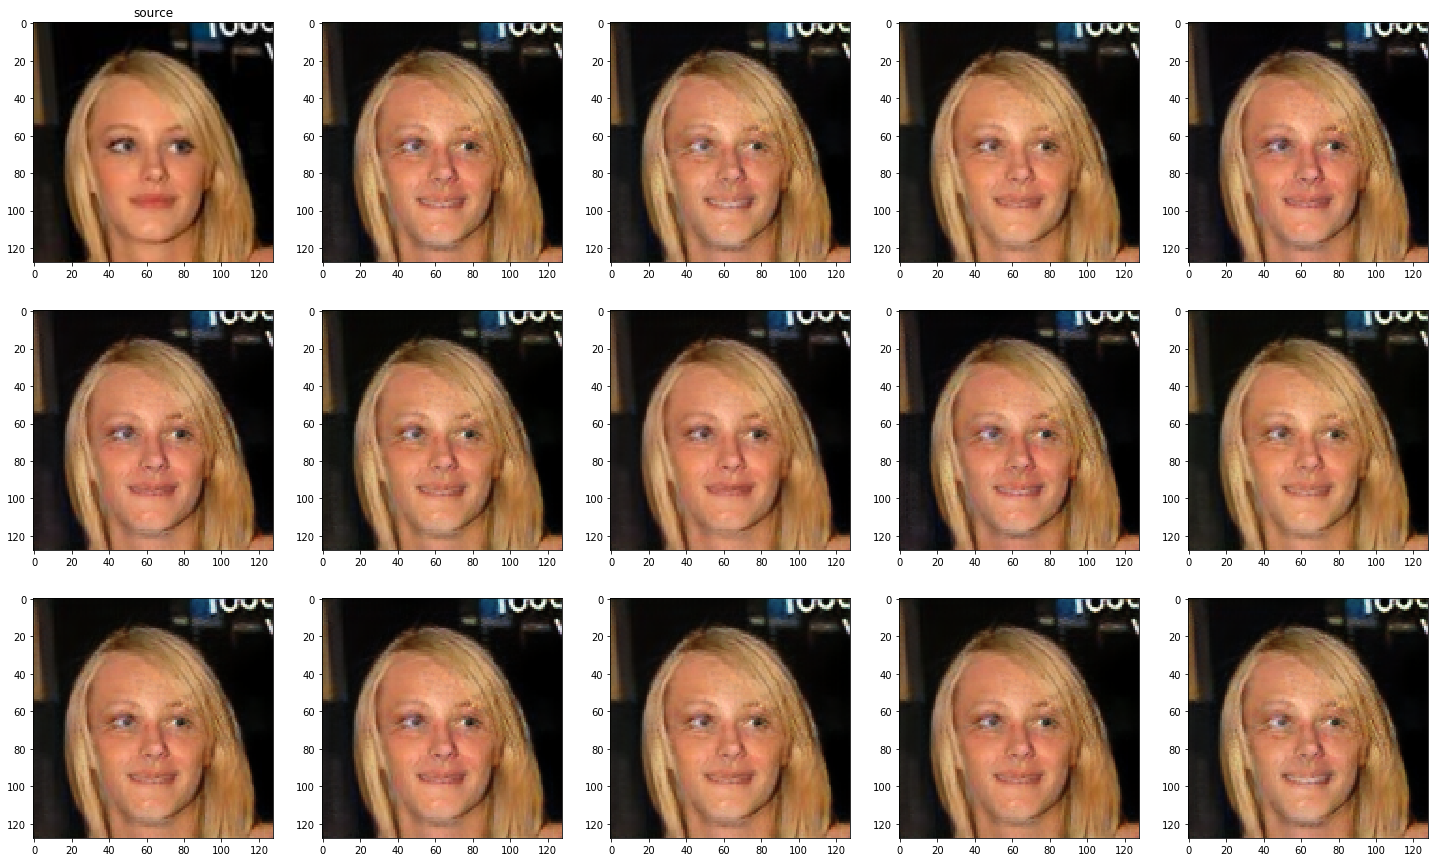

In [21]:
length = 3
width = 5
images = data["target"][0]

np.random.seed(0)
a = np.random.choice(np.arange(num), length*width-1, False)
fig = plt.figure(figsize=(5*width, 5*length))
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images[a[i]])

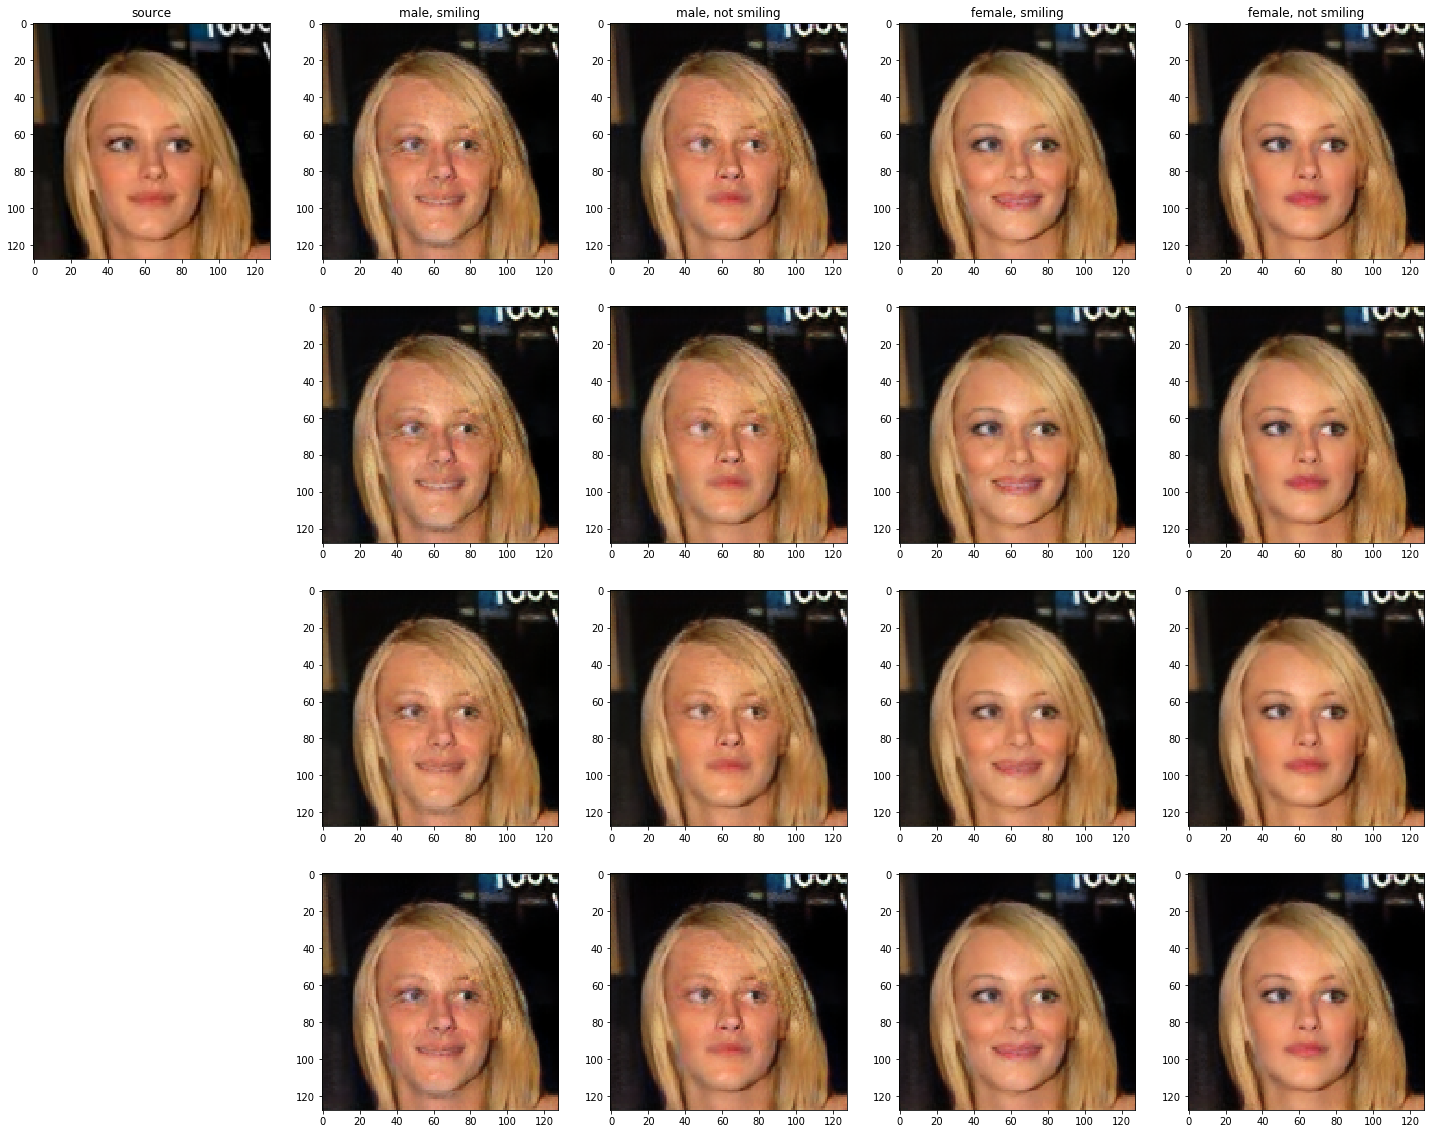

In [22]:
length = 4
images = data["target"]

width = len(classes)+1
fig = plt.figure(figsize=(5*width, 5*length))
np.random.seed(0)
a = np.random.choice(np.arange(num), length, False)
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length):
    for j in classes:
        index = i*(len(classes)+1)+j+2
        ax = fig.add_subplot(length, width, index)
        ax.imshow(images[j][a[i]])
        if i == 0:
            ax.set_title(label_discription[j])

## Encoder

### Restriction Distribution

In [23]:
sample_num = 1000

trace = []
m = np.random.randn(1000, 3)
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"desired", 
                          marker = dict(size=5, opacity=0.2)))

m = mu_list[:sample_num,0:]
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                          marker = dict(size=3, opacity=0.8)))


layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

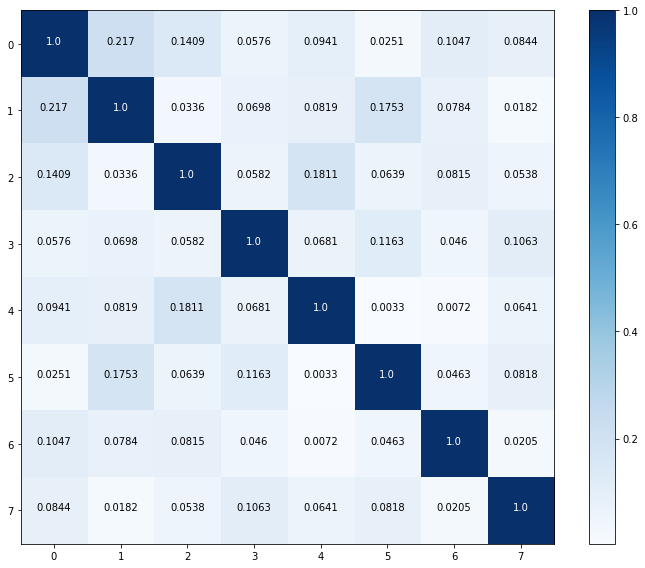

In [24]:
def plot_correlation_matrix(cm):
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j], 4)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
plot_correlation_matrix(np.abs(np.array(corrcoef(torch.tensor(mu_list.T)))))

Text(0.5, 1.0, 'plt histogram')

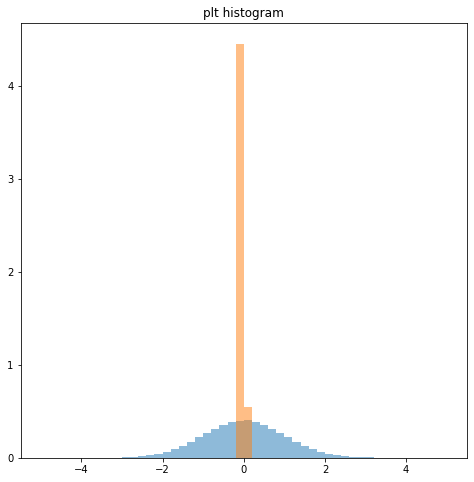

In [25]:
a = np.random.randn(100000, 8)
b = mu_list[:,:]
a = torch.tensor(a)
b = torch.tensor(b)

range_max = 5
bins = 50

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.hist(cuda2numpy(a[:,0]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="desired");
ax.hist(cuda2numpy(b[:,3]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="training")
ax.set_title("plt histogram")

### Distribution of encoded features

In [26]:
num = 10
batch_num = num
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [27]:
def get_style_score(a, b):
    c = a.reshape(1, -1, ndim)
    d = c.repeat(c.shape[1], 0)
    for i in range(d.shape[0]):
        d[i,:,:] = np.roll(d[i,:,:], i, axis=0)
        
    e = b.reshape(1, -1, ndim)
    f = e.repeat(e.shape[1], 0)
    g = np.sqrt(np.sum((f-d)**2, axis=2))
    
    i = g[0:1]
    j = np.mean(g[1:], axis=0, keepdims=True)
    k = i/j
    h = np.concatenate([i,j,k], axis=0).T
    all_score = pd.DataFrame(h, columns=["same style", "different style", "score"])
    mean_score = pd.DataFrame(np.mean(h, axis=0, keepdims=True), index=["mean"], columns=["same style", "different style", "score"])
    
    return all_score, mean_score

In [28]:
def get_distribution(sg, testset, device, classes, batch_num, each_num):
    dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_num, shuffle=False)
    data = {}
    for cl in classes:
        data[cl] = {}
        for target in classes:
            data[cl][target] = {}
            
    for itr, x in enumerate(dataloader):
        cl = int(itr*batch_num/each_num)
        for target in classes:
            netE.eval()
            data_image = x[0].to(device)
            data_label = x[1].to(device)

            target_label = torch.ones(data_image.shape[0], dtype=torch.long, device="cpu")*target

            # random target
            if styleINdataset:
                target_random_image, [_,random_feature,_,_,_] = sg.G_transformation(target_label, data_image, True, data_image[list(np.arange(data_image.shape[0])[::-1])])
            else:
                target_random_image, random_feature = sg.G_transformation(target_label, data_image, False)

            # source target
            target_source_image, [_,source_feature,_,_,_] = sg.G_transformation(target_label, data_image, True, data_image)

            # get encoded features
            _, random_encoded, _, _, _ = sg.E(target_random_image)
            _, source_encoded, _, _, _ = sg.E(target_source_image)

            var_list = [
                data_image, 
                data_label,
                target_random_image,
                target_source_image,
                random_feature,
                source_feature,
                random_encoded,
                source_encoded,
            ]
            for var in var_list:
                for (key, value) in locals().items():
                    if id(value) == id(var):
                        var_name = key
                if itr*batch_num%each_num==0:
                    data[cl][target][var_name] = cuda2numpy(var)
                else:
                    data[cl][target][var_name] = np.concatenate([data[cl][target][var_name],cuda2numpy(var)], axis=0)
                    
    data["score"] = {}
    for source_label in classes:
        data["score"][source_label] = {}
        for target_label in classes:
            data["score"][source_label][target_label] = {}
            for feature_type in ["source", "random"]:
                data["score"][source_label][target_label][feature_type] = {}
                if feature_type=="source":
                    a = data[source_label][target_label]["source_feature"]
                    b = data[source_label][target_label]["source_encoded"]
                elif feature_type=="random":
                    a = data[source_label][target_label]["random_feature"]
                    b = data[source_label][target_label]["random_encoded"]

                all_score, mean_score = get_style_score(a, b)
                data["score"][source_label][target_label][feature_type]["all"] = all_score
                data["score"][source_label][target_label][feature_type]["mean"] = mean_score
    return data

In [29]:
data = get_distribution(sg, testset, device, classes, batch_num, num)

In [32]:
data["score"][0][1]["random"]["mean"]

,same style,different style,score
mean,2.55739,2.557627,1.005774


In [33]:
data["score"][0][1]["source"]["mean"]

,same style,different style,score
mean,0.000437,0.001735,0.235437


In [30]:
# target under source condition
data_num = 8
source_label = 1
target_label = 3

a = data[source_label][target_label]["random_feature"].reshape(-1,1,ndim)
b = data[source_label][target_label]["random_encoded"].reshape(-1,1,ndim)

trace = []
for i in range(data_num):
    m = np.concatenate([a[i], b[i]], axis=0)
    _x = m[:, 0] 
    _y = m[:, 1]
    _z = m[:, 2]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{i}", 
                              marker = dict(size=5)))
    
layout = go.Layout(width=500, height=500)    
fig = dict(data=trace, layout=layout)
iplot(fig)

In [31]:
# target under source condition
data_num = 8
source_label = 0
target_label = 1

a = data[source_label][target_label]["source_feature"].reshape(-1,1,ndim)
b = data[source_label][target_label]["source_encoded"].reshape(-1,1,ndim)

trace = []
for i in range(data_num):
    m = np.concatenate([a[i], b[i]], axis=0)
    _x = m[:, 0] 
    _y = m[:, 1]
    _z = m[:, 2]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{i}", 
                              marker = dict(size=5)))
    
layout = go.Layout(width=500, height=500)    
fig = dict(data=trace, layout=layout)
iplot(fig)

## PRDC

### data

In [180]:
num = 1000
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [181]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if styleINdataset:
        _, mu, _, _, _ = netE(data_image)
    if itr==0:
        if styleINdataset:
            mu_list = cuda2cpu(mu)
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        if styleINdataset:
            mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
if styleINdataset:
    latent = mu_list
else:
    latent = np.random.randn(num, ndim)

In [36]:
index = len(testset) - 11
# index = len(testset)//len(classes) - 16
if styleINdataset:
    latent_list = [latent[labels==0],
                   latent[labels==1],
                   latent[labels==2],
                   latent[labels==3]]
else:
    latent_list = latent
data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=False)

### evaluation

In [37]:
fe_list = ["vgg-initialization", 
           "vgg-ImageNet", 
           "vgg-CelebA"]

In [38]:
ge = GAN_evaluation(fe_list[0], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.968,
 'recall': 0.0,
 'density': 1.0082000000000002,
 'coverage': 0.187}

In [39]:
ge = GAN_evaluation(fe_list[1], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.838,
 'recall': 0.0,
 'density': 0.5176000000000001,
 'coverage': 0.064}

In [40]:
ge = GAN_evaluation(fe_list[2], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.996, 'recall': 0.206, 'density': 1.0674, 'coverage': 0.173}

In [41]:
def evaluation_init(fe_list, classes, metrics):
    GAN_eval = {}
    for fe in fe_list:
        GAN_eval[fe] = {}
        for source_label in classes:
            GAN_eval[fe][source_label] = {}
            for target_label in classes:
                GAN_eval[fe][source_label][target_label] = {}
                GAN_eval[fe][source_label][target_label] = {}
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric] = []
    return GAN_eval

In [42]:
sample_num = 100
init = True

if init:
    GAN_eval = evaluation_init(fe_list, classes, metrics)
    start = 0
else:
    start = len(GAN_eval[fe_list[0]][0][0]["coverage"])
    
for i in range(sample_num):
    clear_output(wait=True)
    print(i)
    for source_label in classes:
        index = source_label*num + (start+i)
        data, label = get_samples(netG, netE, testset, index, latent_list, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=False)
        for target_label in classes:
            for fe in fe_list:
                ge = GAN_evaluation(fe, device, classes, [target_label])
                metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric].append(metrics[metric])

99
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num rea

In [43]:
save = True
path = f"../data/results/03/03_GAN_evaluation_{styleINdataset_or_not}{restriction_type}.pkl"

if save:
    pickle_save(GAN_eval, path)